# Light GBM on KKBox's Music Recommendation System 

In this notebook, we will fit a light GBM model to the data, calculate the accuracies on different data splits, run a grid search to extract the best model and build evaluation metrics to validate how well our model fits the data.

In [4]:
#Importing libraries
import numpy as np
import pandas as pd
import lightgbm as lgb
import datetime
import math
import gc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import random
import matplotlib.pyplot as plt
import graphviz
import warnings
warnings.filterwarnings('ignore')

# 1. Loading Data

While loading the data, we will convert the categorical variables to type: object to be able to change it to Categorical variable in the future

In [4]:
print('Loading data...')
train = pd.read_csv('train.csv', dtype={'msno' : 'object',
                                                 'source_system_tab' : 'object',
                                                 'source_screen_name' : 'object',
                                                 'source_type' : 'object',
                                                 'target' : np.uint8,
                                                 'song_id' : 'object'})
test = pd.read_csv('test.csv', dtype={'msno' : 'object',
                                               'source_system_tab' : 'object',
                                               'source_screen_name' : 'object',
                                               'source_type' : 'object',
                                               'song_id' : 'object'})
songs = pd.read_csv('songs.csv',dtype={'genre_ids': 'object',
                                                    'language' : 'object',
                                                    'artist_name' : 'object',
                                                    'composer' : 'object',
                                                    'lyricist' : 'object',
                                                    'song_id' : 'object'})
members = pd.read_csv('members.csv',dtype={'city' : 'object',
                                                    'bd' : np.uint8,
                                                    'gender' : 'object',
                                                    'registered_via' : 'object'},
                     parse_dates=['registration_init_time','expiration_date'])
songs_extra = pd.read_csv('song_extra_info.csv')
print('Done loading...')

Loading data...
Done loading...


# 2. Data Processing for LightGBM

In this section, we will clean and transform the data and make it ready for feature extraction.

#### 2.1 Convert object type to category type

In [5]:
def object2cat(df):
    object_cols = list(df.select_dtypes(include=['object']).columns)
    for col in object_cols:
        df[col]=df[col].astype('category')
object2cat(train)
object2cat(test)
object2cat(songs)
object2cat(members)

In [6]:
#test case for object2cat
assert train['msno'].dtype == 'category'
assert test['source_system_tab'].dtype == 'category'
assert songs['language'].dtype == 'category'
assert members['city'].dtype == 'category'


The test cases in the above grid will make sure that we are getting the right column types.

In [7]:
songs_extra.head()

,song_id,name,isrc
0,LP7pLJoJFBvyuUwvu+oLzjT+bI+UeBPURCecJsX1jjs=,我們,TWUM71200043
1,ClazTFnk6r0Bnuie44bocdNMM3rdlrq0bCGAsGUWcHE=,Let Me Love You,QMZSY1600015
2,u2ja/bZE3zhCGxvbbOB3zOoUjx27u40cf5g09UXMoKQ=,原諒我,TWA530887303
3,92Fqsy0+p6+RHe2EoLKjHahORHR1Kq1TBJoClW9v+Ts=,Classic,USSM11301446
4,0QFmz/+rJy1Q56C1DuYqT9hKKqi5TUqx0sN0IwvoHrw=,愛投羅網,TWA471306001


In the grid below, we encorporate the data cleaning and transformation. Data cleaning involves removing/imputing the NA value. We will now merge the data from different csv files to one data frame. The grid below also contains a function which would extract year from the isrc_id.

#### 2.2 Merging the Data

In this section, we will merge the different csv files to one dataframe

In [8]:
print('Data merging...')

# Merging song with train and test dataframes
train = train.merge(songs, on='song_id', how='left')
test = test.merge(songs, on='song_id', how='left')

# Data Extraction/Transformation - Extracting days, 
# months and years from expiratin and registration time 
members['membership_days'] = members['expiration_date'].subtract(
    members['registration_init_time']).dt.days.astype(int)

members['registration_year'] = members['registration_init_time'].dt.year
members['registration_month'] = members['registration_init_time'].dt.month
members['registration_date'] = members['registration_init_time'].dt.day

members['expiration_year'] = members['expiration_date'].dt.year
members['expiration_month'] = members['expiration_date'].dt.month
members['expiration_date'] = members['expiration_date'].dt.day
members = members.drop(['registration_init_time'], axis=1)


# Converting isrc id to year
def isrc_to_year(isrc):
    if type(isrc) == str:
        if int(isrc[5:7]) > 17:
            return 1900 + int(isrc[5:7])
        else:
            return 2000 + int(isrc[5:7])
    else:
        return np.nan
    

#extracting the year of the song from isrc        
songs_extra['song_year'] = songs_extra['isrc'].apply(isrc_to_year)

#Dropping isrc and name from songs_extra
songs_extra.drop(['isrc', 'name'], axis = 1, inplace = True)

train = train.merge(members, on='msno', how='left')
train.msno = train.msno.astype('category')
test = test.merge(members, on='msno', how='left')
test.msno = test.msno.astype('category')

train = train.merge(songs_extra, on = 'song_id', how = 'left')
train.song_length.fillna(200000,inplace=True)
train.song_length = train.song_length.astype(np.uint32)
train.song_id = train.song_id.astype('category')


test = test.merge(songs_extra, on = 'song_id', how = 'left')
test.song_length.fillna(200000,inplace=True)
test.song_length = test.song_length.astype(np.uint32)
test.song_id = test.song_id.astype('category')

#deleting redundant dataframes

del members, songs; gc.collect();

print('Done merging...')

Data merging...
Done merging...


In [9]:
#testing isrc_to_year
assert len(songs_extra['song_year']) != 0


Let's check if the train dataframe has the right column types.

In [10]:
train.dtypes

msno                  category
song_id               category
source_system_tab     category
source_screen_name    category
source_type           category
target                   uint8
song_length             uint32
genre_ids             category
artist_name           category
composer              category
lyricist              category
language              category
city                  category
bd                       uint8
gender                category
registered_via        category
expiration_date          int64
membership_days          int64
registration_year        int64
registration_month       int64
registration_date        int64
expiration_year          int64
expiration_month         int64
song_year              float64
dtype: object

Let's now perform some feature engineering on the existing features. In this, we extract new features from the existing ones and impute the data to fill the NAs.

# 3. Feature Engineering

In this section, we will extract new features from the existing dataset. This will result in a few new features which will help us in predicting the target better

#### 3.1 Adding new features

We extract things like genre count, lyricists count, featured count etc.

In [11]:
print ("Adding new features")

#counting genre_id
def genre_id_count(x):
    if x == 'no_genre_id':
        return 0
    else:
        return x.count('|') + 1


#filling NA in place of null values
train['genre_ids'].cat.add_categories('no_genre_id').fillna('no_genre_id',inplace=True)
test['genre_ids'].cat.add_categories('no_genre_id').fillna('no_genre_id',inplace=True)
train['genre_ids_count'] = train['genre_ids'].apply(genre_id_count).astype(np.int8)
test['genre_ids_count'] = test['genre_ids'].apply(genre_id_count).astype(np.int8)


# Splitting the lyricists by ['|', '/', '\\', ';'] and counting the number of Lyricists
def lyricist_count(x):
    if x == 'no_lyricist':
        return 0
    else:
        return sum(map(x.count, ['|', '/', '\\', ';'])) + 1
    return sum(map(x.count, ['|', '/', '\\', ';']))

train['lyricist'].cat.add_categories('no_lyricist').fillna('no_lyricist',inplace=True)
test['lyricist'].cat.add_categories('no_lyricist').fillna('no_lyricist',inplace=True)
train['lyricists_count'] = train['lyricist'].apply(lyricist_count).astype(np.int8)
test['lyricists_count'] = test['lyricist'].apply(lyricist_count).astype(np.int8)


# Splitting the comoser by ['|', '/', '\\', ';'] and counting the number of Lyricists
def composer_count(x):
    if x == 'no_composer':
        return 0
    else:
        return sum(map(x.count, ['|', '/', '\\', ';'])) + 1

train['composer'].cat.add_categories('no_composer').fillna('no_composer',inplace=True)
test['composer'].cat.add_categories('no_composer').fillna('no_composer',inplace=True)
train['composer_count'] = train['composer'].apply(composer_count).astype(np.int8)
test['composer_count'] = test['composer'].apply(composer_count).astype(np.int8)

# Checking for feat in the column value
def is_featured(x):
    if 'feat' in str(x) :
        return 1
    return 0

train['artist_name'].cat.add_categories('no_artist').fillna('no_artist',inplace=True)
test['artist_name'].cat.add_categories('no_artist').fillna('no_artist',inplace=True)
train['is_featured'] = train['artist_name'].apply(is_featured).astype(np.int8)
test['is_featured'] = test['artist_name'].apply(is_featured).astype(np.int8)

# Splitting the artists by [and, ',', feat, &] and counting the number of artists
def artist_count(x):
    if x == 'no_artist':
        return 0
    else:
        return x.count('and') + x.count(',') + x.count('feat') + x.count('&')

train['artist_count'] = train['artist_name'].apply(artist_count).astype(np.int8)
test['artist_count'] = test['artist_name'].apply(artist_count).astype(np.int8)

Adding new features


In [12]:
#testing above functions

#testing genre_id_count
assert len(train['genre_ids_count']) != 0
assert len(test['genre_ids_count']) != 0

#testing composer_count
assert len(train['composer_count']) != 0
assert len(train['composer_count']) != 0

#testing lyricist_count
assert len(train['lyricists_count']) != 0
assert len(test['lyricists_count']) != 0

#testing is_feat
assert len(train['is_featured']) != 0
assert len(test['is_featured']) != 0

#testing artist_count
assert len(train['artist_count']) != 0
assert len(test['artist_count']) != 0

In the below grid will extract even more features from the songs data like the length of the song, the language, etc.. 

In [13]:
# if artist is same as composer
train['artist_composer'] = (train['artist_name'].astype("object") == train['composer']
                            .astype("object")).astype(np.int8)
test['artist_composer'] = (test['artist_name'].astype("object") == test['composer']
                           .astype("object")).astype(np.int8)

# if artist, lyricist and composer are all three same
train['artist_composer_lyricist'] = ((train['artist_name'].astype("object") 
                                      == train['composer'].astype("object")) 
                                     & (train['artist_name'].astype("object")
                                        == train['lyricist'].astype("object"))
                                     & (train['composer'].astype("object")
                                        == train['lyricist'].astype("object"))
                                    ).astype(np.int8)
test['artist_composer_lyricist'] = ((test['artist_name'].astype("object") 
                                     == test['composer'].astype("object")) 
                                    & (test['artist_name'].astype("object")
                                       == test['lyricist'].astype("object"))
                                    & (test['composer'].astype("object") 
                                       == test['lyricist'].astype("object"))
                                   ).astype(np.int8)

# is song language 17 or 45. 
def song_lang_boolean(x):
    if '17.0' in str(x) or '45.0' in str(x):
        return 1
    return 0

train['song_lang_boolean'] = train['language'].apply(song_lang_boolean).astype(np.int8)
test['song_lang_boolean'] = test['language'].apply(song_lang_boolean).astype(np.int8)

_mean_song_length = np.mean(train['song_length'])
def smaller_song(x):
    if x < _mean_song_length:
        return 1
    return 0

train['smaller_song'] = train['song_length'].apply(smaller_song).astype(np.int8)
test['smaller_song'] = test['song_length'].apply(smaller_song).astype(np.int8)

# number of times a song has been played before
_dict_count_song_played_train = {k: v for k, v in train['song_id']
                                 .value_counts().iteritems()}
_dict_count_song_played_test = {k: v for k, v in test['song_id']
                                .value_counts().iteritems()}

def count_song_played(x):
    try:
        return _dict_count_song_played_train[x]
    except KeyError:
        try:
            return _dict_count_song_played_test[x]
        except KeyError:
            return 0
    
train['count_song_played'] = train['song_id'].apply(count_song_played).astype(np.int64)
test['count_song_played'] = test['song_id'].apply(count_song_played).astype(np.int64)

# number of times the artist has been played
_dict_count_artist_played_train = {k: v for k, v in train['artist_name']
                                   .value_counts().iteritems()}
_dict_count_artist_played_test = {k: v for k, v in test['artist_name']
                                  .value_counts().iteritems()}

def count_artist_played(x):
    try:
        return _dict_count_artist_played_train[x]
    except KeyError:
        try:
            return _dict_count_artist_played_test[x]
        except KeyError:
            return 0

train['count_artist_played'] = train['artist_name'].apply(count_artist_played).astype(np.int64)
test['count_artist_played'] = test['artist_name'].apply(count_artist_played).astype(np.int64)


print("Done adding features")

Done adding features


In [14]:
#testing the functions

#testing song_lang_boolean
assert train['song_lang_boolean'][0] == 0
assert train['song_lang_boolean'][58] == 1

#testing smaller_song
assert len(test['smaller_song']) != 0
assert len(train['smaller_song']) != 0

#testing count_song_played
assert 'count_song_played' in train
assert len(train['count_artist_played']) != 0
assert 'count_song_played' in test
assert len(test['count_artist_played']) != 0

Next, let's create train, test and validation sets from the original data.

# 4. Saving the data to local

We will save the data to the local for future use.

In [2]:
train.to_csv("processed_train_1.csv") #Saving file to local
test.to_csv("test_1.csv") #Saving test file to local

In [17]:
del songs_extra #Removing unwanted data from memory

In [18]:
gc.collect()

140

Now let's read the processed data back in the memory. 

In [5]:
data = pd.read_csv("processed_train_1.csv") 

In [6]:
data.head()

,Unnamed: 0,msno,song_id,source_system_tab,source_screen_name,source_type,target,song_length,genre_ids,artist_name,...,lyricists_count,composer_count,is_featured,artist_count,artist_composer,artist_composer_lyricist,song_lang_boolean,smaller_song,count_song_played,count_artist_played
0,0,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,BBzumQNXUHKdEBOB7mAJuzok+IJA1c2Ryg/yzTF6tik=,explore,Explore,online-playlist,1,206471,359,Bastille,...,1,2,0,0,0,0,0,1,215,1140
1,1,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,bhp/MpSNoqoxOIB+/l8WPqu6jldth4DIpCm3ayXnJqM=,my library,Local playlist more,local-playlist,1,284584,1259,Various Artists,...,1,1,0,0,0,0,0,0,1,303616
2,2,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,JNWfrrC7zNN7BdMpsISKa4Mw+xVJYNnxXh3/Epw7QgY=,my library,Local playlist more,local-playlist,1,225396,1259,Nas,...,1,1,0,0,0,0,0,1,4,289
3,3,Xumu+NIjS6QYVxDS4/t3SawvJ7viT9hPKXmf0RtLNx8=,2A87tzfnJTSWqD7gIZHisolhe4DMdzkbd6LzO1KHjNs=,my library,Local playlist more,local-playlist,1,255512,1019,Soundway,...,1,1,0,0,0,0,0,0,1,1
4,4,FGtllVqz18RPiwJj/edr2gV78zirAiY/9SmYvia+kCg=,3qm6XTZ6MOCU11x8FIVbAGH5l5uMkT3/ZalWG1oo2Gc=,explore,Explore,online-playlist,1,187802,1011,Brett Young,...,1,3,0,0,0,0,0,1,412,427


In [7]:
train = data.drop(data.columns[0], axis=1)

In the below grid, we extract the training and target values from the data

In [8]:
#Converting the columns to category wherever needed
for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype('category')        

y_train = train['target'].values
X_train = train.drop(['target'], axis=1)

In [9]:
del train
gc.collect()

14

The below grid would split the data into train, validation and test sets.

In [10]:
from sklearn.model_selection import train_test_split
X_train_all, X_test, y_train_all, y_test = train_test_split(X_train, y_train,
                                                            test_size=0.2)

X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all,
                                                  test_size=0.2)

In [11]:
X_train.head()

,msno,song_id,source_system_tab,source_screen_name,source_type,song_length,genre_ids,artist_name,composer,lyricist,...,lyricists_count,composer_count,is_featured,artist_count,artist_composer,artist_composer_lyricist,song_lang_boolean,smaller_song,count_song_played,count_artist_played
3080545,1Lshat/Jzw29ax/Z1BW8cbgqE9gwYQuNHAn1vyU4K6I=,Vh95vgpmcpdngmn7WrkbwnT4j+jjzf3hGb6GVTXQLzQ=,my library,Local playlist more,local-playlist,143464,921,ジブリサウンドトラック,NaN,NaN,...,1,1,0,0,0,0,1,1,19,13274
2066956,gDiC609oMU6T+KRowS1tySjuhzrHtsqFU6keH4VNgcY=,eSerI0GiRKmKVwhbY05QQi6DSRrCz4/vhiyvipqURDk=,search,Search,top-hits-for-artist,228832,465,aMEI (張惠妹),Huang Yun Ren,Leng Wan Mei,...,1,1,0,0,0,0,0,1,2351,82799
4284632,Z56mxjHqnR1FK1d5gkf5ARTxwZF8h0HPI+rHFGRrMHo=,uF93OFuDNiSO4ZXM5HEwEzbxOOvZ+/wUPP7ewSaiMYg=,discover,Online playlist more,online-playlist,226089,1259,Gucci Mane,NaN,NaN,...,1,1,0,0,0,0,0,1,44,108
7079336,wgFA/GOJJh187r3NMqvpT22KeEuWhjm5dauTDzqn7F4=,InNESpQNc6sYaS6LD0mc4vtuIeUbfIqX2wM+8QgKxS4=,discover,Online playlist more,online-playlist,280346,458,池石鎮+胡琳,淩偉文,林明陽/十方,...,2,1,0,0,0,0,0,0,884,884
5710192,Z7EGGBgtVEPJmI7+RyTXLFZP/2i5O/UwaxSGpKX/FWM=,rFLawM8j/vW78o/S3P2GTsmy6HwkTI15P7NF/i9CkX4=,discover,Online playlist more,online-playlist,237505,465|458,林芯儀 (Shennio Lin),吳姝霆,張鵬鵬,...,1,1,0,0,0,0,0,1,4775,12727


# 5. Model Fitting

In the below steps we fit LightGBM model on various data sets to improve the accuracy of the predictions.

#### 5.1 Taking a small sample of data for our first fit

In [12]:
# Sampled train data
idx = random.sample(range(0,X_train.shape[0]), 500000)
y_train = pd.DataFrame(y_train)
X_train_sampled = X_train.iloc[idx]
y_train_sampled = y_train.iloc[idx]

#### 5.2 Let's try to fit a small model to visualise the splitting

For visualization purpose we fit a small model having tree depth of 3. 

In [13]:
small_model = lgb.sklearn.LGBMClassifier(objective='binary',
                                         eval_metric='binary_logloss',
                                         boosting='gbdt',
                                         learning_rate=0.3,
                                         verbose=0,
                                         max_depth= 2)

small_model.fit(X_train, y_train)

LGBMClassifier(boosting='gbdt', boosting_type='gbdt', class_weight=None,
        colsample_bytree=1.0, eval_metric='binary_logloss',
        importance_type='split', learning_rate=0.3, max_depth=2,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective='binary',
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
        verbose=0)

Plotting tree...


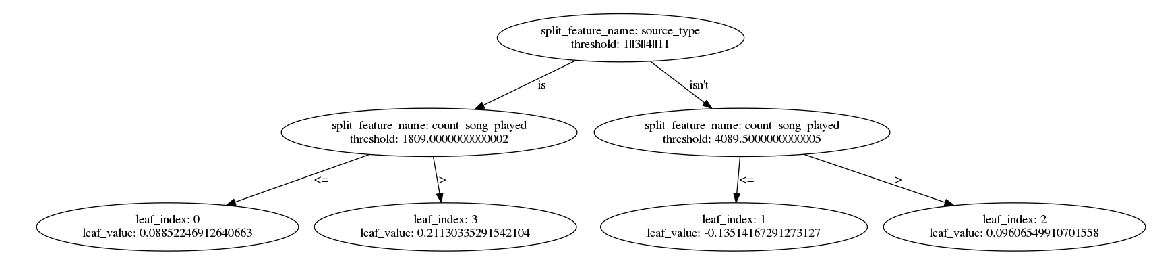

In [14]:
print('Plotting tree...')  # one tree use categorical feature to split
ax = lgb.plot_tree(small_model, tree_index=1, figsize=(20, 8))
plt.show()

From the above tree we can see the features which were given the most importance. The first split happens on Source_type followed by songs played which indicates that these 2 features are the most important when the maxdepth is 3

#### 5.3 Next model is on a sample of .5 million data points

In [15]:
#Fitting a model on sampled data
sk_reg = lgb.sklearn.LGBMClassifier(
         objective='binary',
         eval_metric='binary_logloss',
         boosting='gbdt',
         learning_rate=0.3 ,
         verbose=0,
         num_leaves=600,
         bagging_freq= 1,
         feature_fraction= 0.9,
         max_bin= 256,
         max_depth= 300,
         num_rounds= 200,
)


sk_reg.fit(X_train_sampled, y_train_sampled)

LGBMClassifier(bagging_freq=1, bagging_seed=1, boosting='gbdt',
        boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        eval_metric='binary_logloss', feature_fraction=0.9,
        feature_fraction_seed=1, importance_type='split',
        learning_rate=0.3, max_bin=256, max_depth=300,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=600, num_rounds=200,
        objective='binary', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, verbose=0)

In [16]:
predicted = sk_reg.predict(X_val)
accuracy = accuracy_score(y_val, predicted)
print(f'Mean accuracy score: {accuracy:.3}')

Mean accuracy score: 0.685


We can see that the accuracy of the model is .685 on the sampled data set. Next, let's check the features which were given the most importance in the feature selection section.

#### 5.4 Feature selection

In the below grid we will see the feature importance for the above model

                   cols    imp
0                  msno  37637
32    count_song_played  11544
1               song_id  11347
7           artist_name   8607
5           song_length   6228
33  count_artist_played   5983
16      membership_days   5044
8              composer   4990
22            song_year   3993
19    registration_date   3642


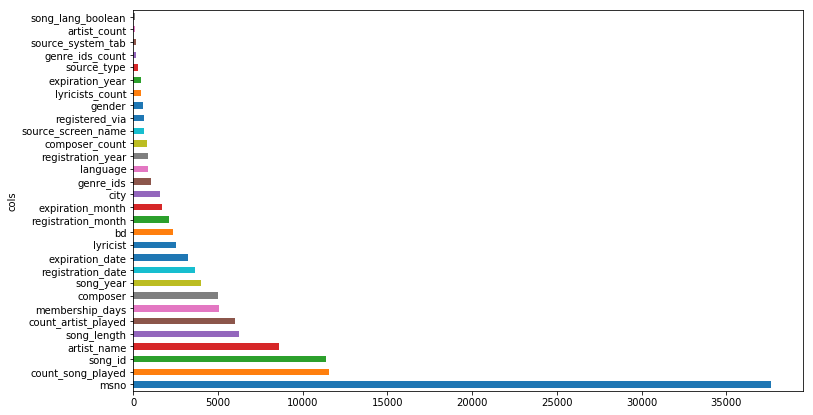

In [17]:
### Feature selection

def lgb_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = lgb_feat_importance(sk_reg, X_train_sampled ); 
print(fi[:10])

def plot_fi(fi):return fi.plot('cols', 'imp', 'barh',
                               figsize=(12,7), legend=False)
plot_fi(fi[:30])
plt.show()

From the above graph, we can see that the most important feature for the above model was msno. which means that the most important feature that the model depends on is the user who is listening to the song, followed by the number of times the song was played. 

#### 5.5 Next, we do a grid search to get the best parameters with maximum accuracy on sampled data

The below code would give us the best parameters with maximum accuracy on predicted variable.

In [29]:
# Pipeline and grid search
pipe_dt = Pipeline([('clf', lgb.sklearn.LGBMClassifier())]) # Estimator: ML algorithm

grid_params = dict(
         clf__objective=['binary'],
         clf__eval_metric=['binary_logloss'],
         clf__boosting_type=['gbdt'],
         clf__learning_rate=[0.3] ,
         clf__verbose=[0],
         clf__num_leaves=[300, 350, 250],
         clf__feature_fraction= [0.9],
         clf__max_bin= [256],
         clf__max_depth= [200, 150, 250],
         clf__num_rounds= [200])
gs = GridSearchCV(estimator=pipe_dt,  
                  param_grid=grid_params,
                  scoring='accuracy',
                  cv=5)

gs.fit(X_train_sampled, y_train_sampled)
f"{gs.score(X_test, y_test):.4f}"

'0.6851'

In [18]:
# Best algorithm with best hyperparameters 
# (need to fit it to find specific model parameters)
print(gs.best_estimator_)

# Best model with specific model parameters
gs.best_estimator_.get_params()['clf']

Pipeline(memory=None,
     steps=[('clf', LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        eval_metric='binary_logloss', feature_fraction=0.9,
        feature_fraction_seed=1, importance_type='split',
        learning_rate=0.3, max_bin=256, max_depth=250,
        min_child_samples=20, min_...da=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, verbose=0))])


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        eval_metric='binary_logloss', feature_fraction=0.9,
        feature_fraction_seed=1, importance_type='split',
        learning_rate=0.3, max_bin=256, max_depth=250,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=300, num_rounds=200,
        objective='binary', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0, verbose=0)

The best score that we get on the sampled data set is .685 with following best parameters:
objective='binary',
eval_metric='binary_logloss'
boosting='gbdt'
learning_rate=0.3 
verbose=0
num_leaves=600
bagging_freq= 1
feature_fraction=0.9
max_bin=256
max_depth=300
num_rounds=200

#### 5.6 Fitting Best Model on all the Data

Next, we fit the best model that we got from the grid search to all the data that we have. This should give us a better accuracy.

In [18]:
#Fitting the best model on all the data
Final_model = lgb.sklearn.LGBMClassifier(objective='binary',
                                         eval_metric='binary_logloss',
                                         boosting='gbdt',
                                         learning_rate=0.3 ,
                                         verbose=0,
                                         num_leaves=600,
                                         bagging_freq= 1,
                                         feature_fraction= 0.9,
                                         max_bin= 256,
                                         max_depth= 300,
                                         num_rounds= 200)


In [19]:
#Validation accuracy
Final_model.fit(X_train, y_train)
predicted = Final_model.predict(X_val)
accuracy = accuracy_score(y_val, predicted)
print(f'Mean accuracy score on validation: {accuracy:.3}')

Mean accuracy score on validation: 0.742


We see that the validation accuracy is 0.742 which is more than what we were getting on the sampled data. Next, let's check the test accuracy.

In [20]:
# Test accuracy
predicted = Final_model.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Mean accuracy score test: {accuracy:.3}')

Mean accuracy score test: 0.742


The test accuracy is pretty close to the validation accuracy of 0.742 which suggests that we had a good split of test and validation sets. Also, our accuracy has increased from 68.5% to 74.2% just by increasing the data.

# 6. Evaluation Metric

Let's create an evaluation metric to see the precision, recall and fscore of the best model.

In [21]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(y_test, predicted)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))


precision: [0.73751855 0.74709601]
recall: [0.74618197 0.73845285]
fscore: [0.74182497 0.74274928]
support: [732119 743365]


Our precision and recalls are around 74% which is pretty good considering the amouont of data that was available.

#### 6.1 Confusion Matrix

The below code would build a confusion matrix of the true and predicted labels.

Confusion matrix, without normalization
[[546294 185825]
 [194425 548940]]
Normalized confusion matrix
[[0.75 0.25]
 [0.26 0.74]]


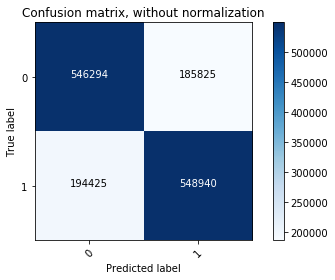

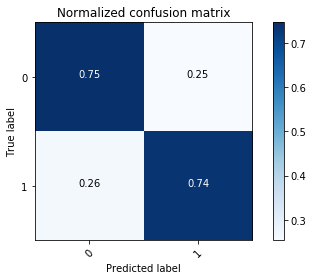

In [22]:
import itertools
from sklearn.metrics import confusion_matrix
class_names = ['0','1']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

From the above confusion matrix we can see that we are predicting the true labels right 75% of the time.


In [24]:
# Predict probability for ROC curve
predicted = Final_model.predict_proba(X_test)

#### 6.2 ROC curve 

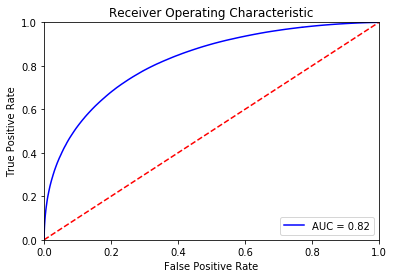

In [25]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

false_positive_rate, true_positive_rate, thresholds = roc_curve(
    y_test, [i[1]for i in predicted])
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate,
         'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The AUC of the above curve is 0.82. 

# 7. Summary

In this notebook, we fit Light GBM to the WSDM dataset. We build different models on sampled and whole dataset. The maximum accuracy we got was 75% which was on the whole data. We were able to improve the accuracy by extarcting momre features. For feature selection and benchmarking features please have a look at the below notebook - 
https://github.com/jyotipmahes/ML_project_621/blob/master/Models/Feature_Engg_Benchmark.ipynb